# 仅使用电子病历信息

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import itertools, logging
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
from datetime import datetime

In [3]:
import joblib

In [4]:
## Testing data 始终不变

In [5]:
df_testing = pd.read_csv(r'D:\data\MIMIC_IV_processed\common\df_eval_common.csv',sep=';')
df_testing = df_testing[~(df_testing.ADMISSION_YEAR_GROUP=='2008 - 2010')]

In [6]:
df_testing.reset_index(drop=True, inplace=True)

## 房颤

In [7]:
LABEL = 'AF'

In [8]:
df_training = pd.read_csv(r'D:\data\MIMIC_IV_processed\common\df_training_'+LABEL+'.csv',sep=';')

In [9]:
#排除2010年之前数据，降低数据迁移影响

df_training = df_training[~(df_training.ADMISSION_YEAR_GROUP=='2008 - 2010')]
df_training.reset_index(drop=True, inplace=True)

In [10]:
df_training[LABEL].value_counts()

AF
0    128416
1     25254
Name: count, dtype: int64

In [11]:
df_testing[LABEL].value_counts()

AF
0    39990
1     6370
Name: count, dtype: int64

In [12]:
df_training.head()

,PATIENTID,STAYID,ADMISSION_TIME,DISCHARGE_TIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,MARITAL_STATUS,RACE,...,GENDER,ADMISSION_YEAR_GROUP,SURGERY_HISTORY,DIAGNOSIS_HISTORY,LAB_RESULT,AF,AS,MI,CI,CASE
0,18418634,21025557,2116-02-28 04:29:00,2116-03-12 17:00:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_medicare,lan_other,ms_single,race_white,...,gender_f,2011 - 2013,"icd_9_0390, icd_9_0407, icd_9_0481, icd_9_3893...","icd_9_30000, icd_9_30981, icd_9_311, icd_9_326...","lab_hematocrit_abnormal,lab_hemoglobin_abnorma...",0,0,0,0,0
1,15814891,21120922,2166-03-05 18:24:00,2166-03-12 16:45:00,adm_typ_observation_admit,adm_loc_emergency_room,ins_other,lan_other,ms_married,race_black_african_american,...,gender_f,2011 - 2013,"icd_10_027034z, icd_10_047l3zz, icd_10_0ybn0zx...","icd_10_b9561, icd_10_e1165, icd_10_e119, icd_1...","lab_inr_pt__abnormal,lab_pt_abnormal,lab_ptt_a...",1,1,1,0,1
2,14399274,25646913,2185-11-25 14:27:00,2185-11-28 18:38:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_medicare,lan_other,ms_married,race_white,...,gender_m,2011 - 2013,NaN,NaN,NaN,1,0,0,0,1
3,18227371,23175171,2141-09-22 19:52:00,2141-10-06 17:30:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_other,lan_other,ms_widowed,race_white,...,gender_m,2011 - 2013,NaN,NaN,"lab_bilirubin_normal,lab_blood_normal,lab_gluc...",1,0,1,0,1
4,11039006,24666194,2142-11-19 17:02:00,2142-11-25 14:09:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_medicare,lan_other,ms_widowed,race_white,...,gender_f,2011 - 2013,NaN,NaN,"lab_inr_pt__abnormal,lab_pt_abnormal,lab_ptt_a...",0,0,0,0,0


#### 创建训练数据集

In [13]:
## 定义训练用特征

features_training = [
    'GENDER',
    'AGE_GROUP',
    'ADMISSION_TYPE',
    'DIAGNOSIS_HISTORY',
    'SURGERY_HISTORY',
    'LAB_RESULT',
    'ADMISSION_LOCATION',
    'INSURANCE',
    'LANGUAGE',
    'MARITAL_STATUS',
    'RACE'
    ]      

# 确保所有特征值都是字符串
df_training[features_training] = df_training[features_training].astype(str)

# 初始化 inputs 列表
inputs = []

# 遍历数据框的每一行， 生成observation列，聚集所有特征值，之后在此基础上通过TF-IDF生成特征向量集
for index, row in df_training.iterrows():
    # 用逗号分隔的特征字符串
    observation = ','.join(row[features_training].values)
    observation = observation.replace(',nan', '')
    inputs.append(observation)

# 构建训练数据框
train_data = pd.DataFrame({
    'STAYID': df_training.STAYID,
    'OBSERVATIONS': inputs,
    'LABEL': df_training[LABEL]
})

In [14]:
train_data.head()

,STAYID,OBSERVATIONS,LABEL
0,21025557,"gender_f,age_group_2,adm_typ_ew_emer_,icd_9_30...",0
1,21120922,"gender_f,age_group_4,adm_typ_observation_admit...",1
2,25646913,"gender_m,age_group_9,adm_typ_ew_emer_,adm_loc_...",1
3,23175171,"gender_m,age_group_7,adm_typ_ew_emer_,lab_bili...",1
4,24666194,"gender_f,age_group_8,adm_typ_urgent,lab_inr_pt...",0


#### 创建测试数据集

In [15]:
# 确保所有特征值都是字符串
df_testing[features_training] = df_testing[features_training].astype(str)

# 初始化 inputs 列表
inputs_test = []

# 遍历数据框的每一行
for index, row in df_testing.iterrows():
    # 用逗号分隔的特征字符串
    observation = ','.join(row[features_training].values)
    observation = observation.replace(',nan', '')
    inputs_test.append(observation)

test_data = pd.DataFrame(
    {'STAYID': df_testing.STAYID,
     'OBSERVATIONS': inputs_test,
     'LABEL': df_testing[LABEL]
    })

In [16]:
test_data.head()

,STAYID,OBSERVATIONS,LABEL
0,22595853,"gender_f,age_group_5,adm_typ_urgent,adm_loc_tr...",0
1,22841357,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
2,25742920,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
3,29079034,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
4,24597018,"gender_f,age_group_5,adm_typ_ew_emer_,adm_loc_...",0


In [17]:
test_data[13:19].OBSERVATIONS.tolist()

['gender_m,age_group_8,adm_typ_urgent,lab_inr_pt__abnormal,lab_pt_abnormal,lab_ptt_abnormal,lab_hematocrit_normal,lab_hemoglobin_normal,lab_mch_normal,lab_mchc_normal,lab_mcv_normal,lab_platelet_count_normal,lab_rdw_normal,lab_red_blood_cells_abnormal,lab_white_blood_cells_abnormal,lab_anion_gap_abnormal,lab_bicarbonate_abnormal,lab_calcium__total_abnormal,lab_chloride_normal,lab_creatinine_abnormal,lab_glucose_abnormal,lab_magnesium_normal,lab_phosphate_normal,lab_potassium_normal,lab_sodium_abnormal,lab_urea_nitrogen_abnormal,lab_platelet_smear_normal,lab_absolute_lymphocyte_count_abnormal,lab_basophils_normal,lab_eosinophils_normal,lab_lymphocytes_abnormal,lab_monocytes_normal,lab_neutrophils_abnormal,lab_absolute_basophil_count_abnormal,lab_absolute_eosinophil_count_abnormal,lab_absolute_monocyte_count_abnormal,lab_absolute_neutrophil_count_abnormal,lab_rdw_sd_normal,lab_estimated_gfr__mdrd_equation__normal,lab_troponin_t_abnormal,lab_creatine_kinase__mb_isoenzyme_abnormal,lab_anis

In [18]:
test_data[13:15]

,STAYID,OBSERVATIONS,LABEL
13,24982426,"gender_m,age_group_8,adm_typ_urgent,lab_inr_pt...",1
14,22002850,"gender_m,age_group_3,adm_typ_ew_emer_,lab_trop...",0


## 模型训练

### 使用LGBM, 特征值为2000

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Feature extraction: Convert observations to features using TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer = "word"
                                  , max_features=2000
                                  #, ngram_range = (1,3)
                                  #, max_df = 0.95
                                  #, min_df = 0.05
                                  , dtype = np.float32
                                 )


X_train = vectorizer.fit_transform(train_data['OBSERVATIONS'])

# Label encoding: Convert MI labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data["LABEL"])


X_test = vectorizer.transform(test_data.OBSERVATIONS)
y_test = label_encoder.fit_transform(test_data["LABEL"])


# Model training: Train a RandomForestClassifier
#model = RandomForestClassifier(n_estimators=100, random_state=42)

#model.fit(X_train, y_train)


#model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#    max_depth=1, random_state=0).fit(X_train, y_train)

model = LGBMClassifier()
model.fit(X_train, y_train)

# Model evaluation: Predict on the test set and print the classification report


pred = model.predict(X_test)

conf_mat = confusion_matrix(test_data["LABEL"], pred)

pred_pro = model.predict_proba(X_test)[:,1]

frp_mi, trp_mi, thres_mi = roc_curve(test_data["LABEL"], pred_pro)

auc_val_mi = auc(frp_mi, trp_mi)

print("sensitivity: " + str(round(metrics.recall_score(test_data["LABEL"], pred),2)) + '\n') 
print("specificity: " + str(round(1-metrics.recall_score(1-test_data["LABEL"], pred),2)) + '\n') 
print("discrimination: " + str(round(auc_val_mi,3)) + '\n') 


# Save the model
joblib.dump(model, r'D:\data\MIMIC_IV_processed\common\models\\'+ LABEL+'.pkl')

# Load the model later
#loaded_model = joblib.load('lgbm_model.pkl')

D:\pycharm\project\venv\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 25254, number of negative: 128416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.665718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 389607
[LightGBM] [Info] Number of data points in the train set: 153670, number of used features: 2000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164339 -> initscore=-1.626290
[LightGBM] [Info] Start training from score -1.626290
sensitivity: 0.39

specificity: 0.97

discrimination: 0.883



['D:\\data\\MIMIC_IV_processed\\common\\models\\\\AF.pkl']

In [21]:
df_testing['AF_PRED']=pred

In [22]:
df_testing['AF_PRED_PRO']=pred_pro

In [23]:
df_testing[df_testing.AF_PRED==1].head()

,PATIENTID,STAYID,ADMISSION_TIME,DISCHARGE_TIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,MARITAL_STATUS,RACE,...,SURGERY_HISTORY,DIAGNOSIS_HISTORY,LAB_RESULT,AF,AS,MI,CI,CASE,AF_PRED,AF_PRED_PRO
8,10002221,20195471,2203-06-13 00:00:00,2203-06-16 13:28:00,adm_typ_surgical_same_day_admission,adm_loc_physician_referral,ins_medicare,lan_other,ms_single,race_white,...,nan,"icd_9_2724, icd_9_3051, icd_9_311, icd_9_32723...","lab_inr_pt__abnormal,lab_pt_abnormal",0,0,0,0,0,1,0.568026
11,10002221,21729093,2204-06-27 16:57:00,2204-06-30 12:53:00,adm_typ_observation_admit,adm_loc_clinic_referral,ins_medicare,lan_other,ms_single,race_white,...,icd_10_0srd0j9,"icd_10_d6861, icd_10_e119, icd_10_e669, icd_10...","lab_inr_pt__abnormal,lab_pt_abnormal,lab_ptt_n...",0,0,0,0,0,1,0.592364
12,10002221,29399017,2204-07-17 06:10:00,2204-07-25 14:05:00,adm_typ_ew_emer_,adm_loc_physician_referral,ins_medicare,lan_other,ms_single,race_white,...,"icd_10_0h9u3zz, icd_10_0hcu0zz, icd_10_0srd0j9...","icd_10_c50912, icd_10_d509, icd_10_d6861, icd_...","lab_bilirubin_normal,lab_blood_normal,lab_gluc...",0,0,0,0,0,1,0.567972
13,10002495,24982426,2141-05-22 20:17:00,2141-05-29 17:41:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_medicare,lan_other,ms_married,race_unknown,...,nan,nan,"lab_inr_pt__abnormal,lab_pt_abnormal,lab_ptt_a...",1,0,1,0,1,1,0.638811
18,10004235,22187210,2196-06-20 21:11:00,2196-06-22 13:30:00,adm_typ_direct_emer_,adm_loc_physician_referral,ins_medicaid,lan_other,ms_single,race_black_cape_verdean,...,nan,"icd_9_03842, icd_9_1560, icd_9_1978, icd_9_274...","lab_inr_pt__normal,lab_pt_normal,lab_ptt_norma...",1,0,0,0,1,1,0.676603


In [24]:
test_data[20:25]

,STAYID,OBSERVATIONS,LABEL
20,25970245,"gender_m,age_group_4,adm_typ_surgical_same_day...",1
21,21255400,"gender_m,age_group_7,adm_typ_ew_emer_,lab_bili...",1
22,23517634,"gender_f,age_group_6,adm_typ_observation_admit...",0
23,28691361,"gender_f,age_group_6,adm_typ_observation_admit...",0
24,28731738,"gender_f,age_group_6,adm_typ_observation_admit...",0


In [25]:
# 获取特征重要性
feature_importance = model.feature_importances_

# 获取特征名称
feature_names = vectorizer.get_feature_names_out()

# 创建 DataFrame 并按重要性排序
explaining_df = pd.DataFrame({
    "feature_names": feature_names,
    "scores": feature_importance
}).sort_values(by="scores", ascending=False)
explaining_df[:20]

,feature_names,scores
668,icd_10_z7901,50
1045,icd_9_42732,48
669,icd_10_z7902,46
1597,icd_9_v5861,46
18,age_group_2,43
19,age_group_3,42
27,gender_m,37
21,age_group_5,33
22,age_group_6,32
20,age_group_4,32


Predicted Probability for Sample 0: 0.07


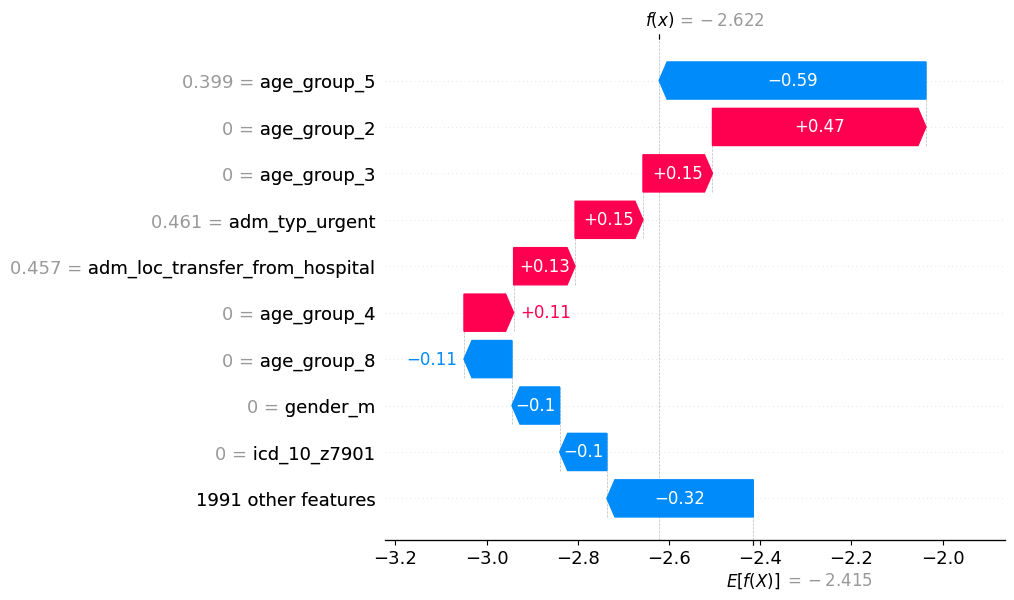

Predicted Probability for Sample 1: 0.04


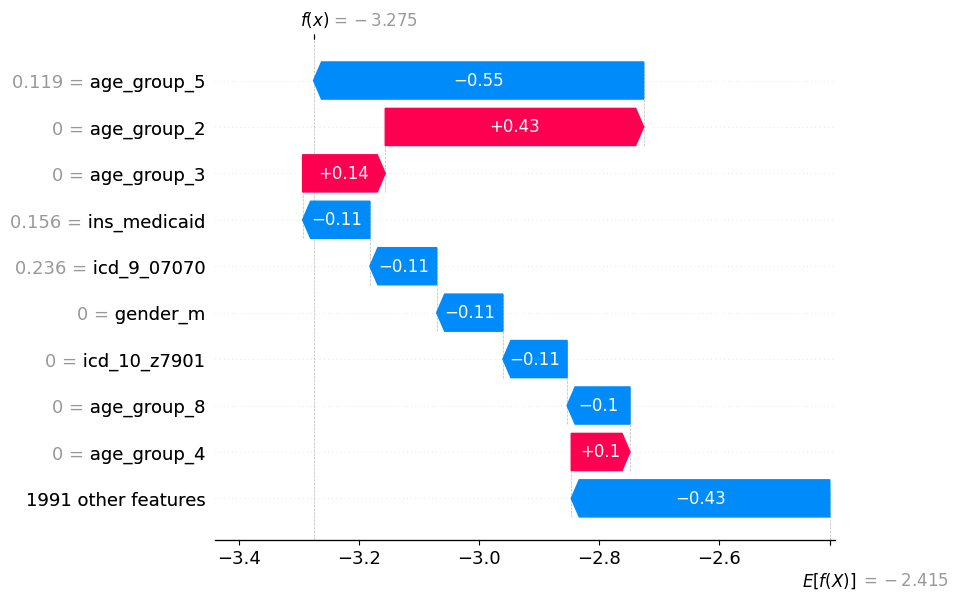

Predicted Probability for Sample 2: 0.02


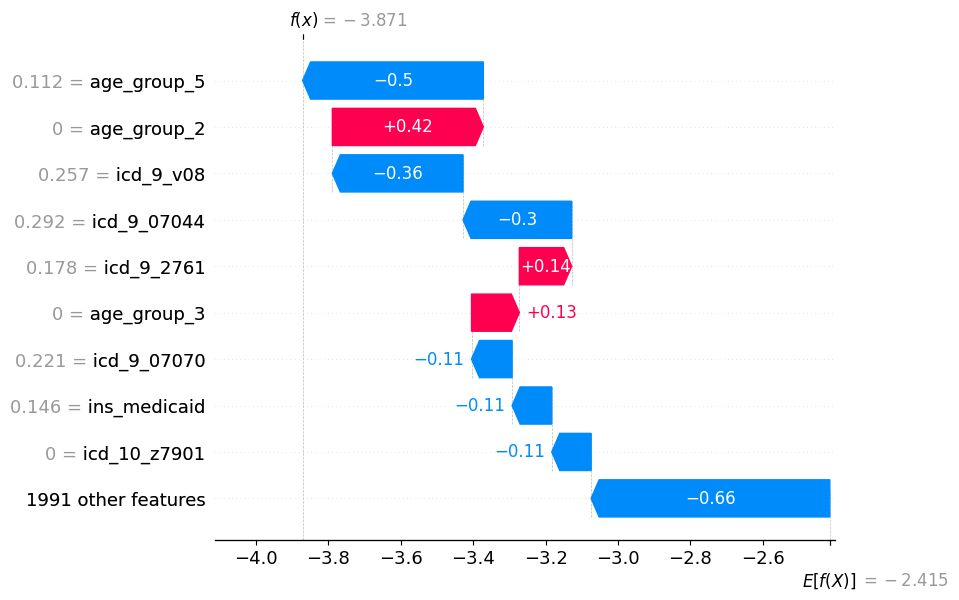

In [26]:
import shap
import numpy as np

# 将稀疏矩阵转换为密集矩阵
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# 创建 SHAP Explainer 对象
explainer = shap.Explainer(model, X_train_dense)


for i in range(0, 3):
    # 选择一个样本进行解释

    shap_values = explainer(X_test_dense[i].reshape(1, -1))

    # 获取样本的 SHAP 值
    shap_values_single = shap_values[0]

    # 输出预测的概率值
    predicted_proba = model.predict_proba(X_test_dense[i].reshape(1, -1))[0, 1]
    print(f"Predicted Probability for Sample {i}: {predicted_proba:.2f}")

    # 使用 waterfall plot 来显示该样本的特征重要性
    shap.waterfall_plot(shap.Explanation(
        values=shap_values_single.values, 
        base_values=shap_values_single.base_values, 
        data=X_test_dense[i],
        feature_names=feature_names
    ))


## 动脉粥样硬化

In [27]:
LABEL = 'AS'

In [28]:
df_training = pd.read_csv(r'D:\data\MIMIC_IV_processed\common\df_training_'+LABEL+'.csv',sep=';')

In [29]:
#排除2010年之前数据，降低数据迁移影响

df_training = df_training[~(df_training.ADMISSION_YEAR_GROUP=='2008 - 2010')]
df_training.reset_index(drop=True, inplace=True)

In [30]:
df_training[LABEL].value_counts()

AS
0    20649
1     3189
Name: count, dtype: int64

In [31]:
df_testing[LABEL].value_counts()

AS
0    45580
1      780
Name: count, dtype: int64

#### 创建训练数据集

In [32]:
## 定义训练用特征

features_training = [
    'GENDER',
    'AGE_GROUP',
    'ADMISSION_TYPE',
    'DIAGNOSIS_HISTORY',
    'SURGERY_HISTORY',
    'LAB_RESULT',
    'ADMISSION_LOCATION',
    'INSURANCE',
    'LANGUAGE',
    'MARITAL_STATUS',
    'RACE'
    ]      

# 确保所有特征值都是字符串
df_training[features_training] = df_training[features_training].astype(str)

# 初始化 inputs 列表
inputs = []

# 遍历数据框的每一行， 生成observation列，聚集所有特征值，之后在此基础上通过TF-IDF生成特征向量集
for index, row in df_training.iterrows():
    # 用逗号分隔的特征字符串
    observation = ','.join(row[features_training].values)
    observation = observation.replace(',nan', '')
    inputs.append(observation)

# 构建训练数据框
train_data = pd.DataFrame({
    'STAYID': df_training.STAYID,
    'OBSERVATIONS': inputs,
    'LABEL': df_training[LABEL]
})

In [33]:
train_data.head()

,STAYID,OBSERVATIONS,LABEL
0,23052645,"gender_m,age_group_2,adm_typ_ew_emer_,adm_loc_...",0
1,24567212,"gender_m,age_group_2,adm_typ_eu_observation,ad...",0
2,23294845,"gender_m,age_group_5,adm_typ_observation_admit...",0
3,26648356,"gender_f,age_group_8,adm_typ_ew_emer_,lab_ptt_...",0
4,24426992,"gender_f,age_group_5,adm_typ_observation_admit...",0


#### 创建测试数据集

In [34]:
# 确保所有特征值都是字符串
df_testing[features_training] = df_testing[features_training].astype(str)

# 初始化 inputs 列表
inputs_test = []

# 遍历数据框的每一行
for index, row in df_testing.iterrows():
    # 用逗号分隔的特征字符串
    observation = ','.join(row[features_training].values)
    observation = observation.replace(',nan', '')
    inputs_test.append(observation)

test_data = pd.DataFrame(
    {'STAYID': df_testing.STAYID,
     'OBSERVATIONS': inputs_test,
     'LABEL': df_testing[LABEL]
    })

In [35]:
test_data.head()

,STAYID,OBSERVATIONS,LABEL
0,22595853,"gender_f,age_group_5,adm_typ_urgent,adm_loc_tr...",0
1,22841357,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
2,25742920,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
3,29079034,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
4,24597018,"gender_f,age_group_5,adm_typ_ew_emer_,adm_loc_...",0


## 模型训练

### 使用LGBM, 特征值为2000

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Feature extraction: Convert observations to features using TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer = "word"
                                  , max_features=2000
                                  #, ngram_range = (1,3)
                                  #, max_df = 0.95
                                  #, min_df = 0.05
                                  , dtype = np.float32
                                 )


X_train = vectorizer.fit_transform(train_data['OBSERVATIONS'])

# Label encoding: Convert MI labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data["LABEL"])


X_test = vectorizer.transform(test_data.OBSERVATIONS)
y_test = label_encoder.fit_transform(test_data["LABEL"])


# Model training: Train a RandomForestClassifier
#model = RandomForestClassifier(n_estimators=100, random_state=42)

#model.fit(X_train, y_train)


#model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#    max_depth=1, random_state=0).fit(X_train, y_train)

model = LGBMClassifier()
model.fit(X_train, y_train)

# Model evaluation: Predict on the test set and print the classification report


pred = model.predict(X_test)

conf_mat = confusion_matrix(test_data["LABEL"], pred)

pred_pro = model.predict_proba(X_test)[:,1]

frp_mi, trp_mi, thres_mi = roc_curve(test_data["LABEL"], pred_pro)

auc_val_mi = auc(frp_mi, trp_mi)

print("sensitivity: " + str(round(metrics.recall_score(test_data["LABEL"], pred),2)) + '\n') 
print("specificity: " + str(round(1-metrics.recall_score(1-test_data["LABEL"], pred),2)) + '\n') 
print("discrimination: " + str(round(auc_val_mi,3)) + '\n') 


# Save the model
joblib.dump(model, r'D:\data\MIMIC_IV_processed\common\models\\'+ LABEL+'.pkl')

# Load the model later
#loaded_model = joblib.load('lgbm_model.pkl')

[LightGBM] [Info] Number of positive: 3189, number of negative: 20649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147894
[LightGBM] [Info] Number of data points in the train set: 23838, number of used features: 2000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.133778 -> initscore=-1.867960
[LightGBM] [Info] Start training from score -1.867960
sensitivity: 0.37

specificity: 0.98

discrimination: 0.869



['D:\\data\\MIMIC_IV_processed\\common\\models\\\\AS.pkl']

In [37]:
df_testing['AS_PRED']=pred

In [38]:
df_testing['AS_PRED_PRO']=pred_pro

In [39]:
df_testing[df_testing.AS_PRED==1].head()

,PATIENTID,STAYID,ADMISSION_TIME,DISCHARGE_TIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,MARITAL_STATUS,RACE,...,LAB_RESULT,AF,AS,MI,CI,CASE,AF_PRED,AF_PRED_PRO,AS_PRED,AS_PRED_PRO
22,10004606,23517634,2159-03-14 20:02:00,2159-03-22 14:00:00,adm_typ_observation_admit,adm_loc_physician_referral,ins_other,lan_other,ms_widowed,race_white,...,nan,0,1,0,0,1,0,0.059369,1,0.790913
24,10004606,28731738,2159-04-05 01:58:00,2159-04-11 19:05:00,adm_typ_observation_admit,adm_loc_emergency_room,ins_other,lan_other,ms_widowed,race_white,...,"lab_bilirubin_normal,lab_blood_normal,lab_gluc...",0,0,0,0,0,0,0.040626,1,0.509310
317,10078072,28804511,2126-09-09 01:32:00,2126-09-20 09:40:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_medicare,lan_other,ms_married,race_white,...,"lab_bilirubin_normal,lab_blood_normal,lab_gluc...",1,0,0,0,1,0,0.301876,1,0.694992
399,10098672,21921527,2141-06-29 22:55:00,2141-07-03 16:52:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_other,lan_other,ms_divorced,race_white,...,"lab_bilirubin_normal,lab_blood_normal,lab_gluc...",0,0,0,0,0,0,0.142682,1,0.599207
459,10109826,23314030,2129-05-21 11:53:00,2129-06-05 14:05:00,adm_typ_observation_admit,adm_loc_physician_referral,ins_other,lan_other,ms_divorced,race_white,...,"lab_bilirubin_normal,lab_blood_normal,lab_gluc...",0,0,0,0,0,0,0.229120,1,0.638716


In [40]:
# 获取特征重要性
feature_importance = model.feature_importances_

# 获取特征名称
feature_names = vectorizer.get_feature_names_out()

# 创建 DataFrame 并按重要性排序
explaining_df = pd.DataFrame({
    "feature_names": feature_names,
    "scores": feature_importance
}).sort_values(by="scores", ascending=False)
explaining_df[:20]

,feature_names,scores
1883,lab_ptt_abnormal,39
19,age_group_2,37
14,adm_typ_eu_observation,32
20,age_group_3,31
21,age_group_4,28
5,adm_loc_physician_referral,28
1070,icd_9_4439,26
28,gender_m,24
920,icd_9_3051,24
1970,ms_married,23


Predicted Probability for Sample 0: 0.08


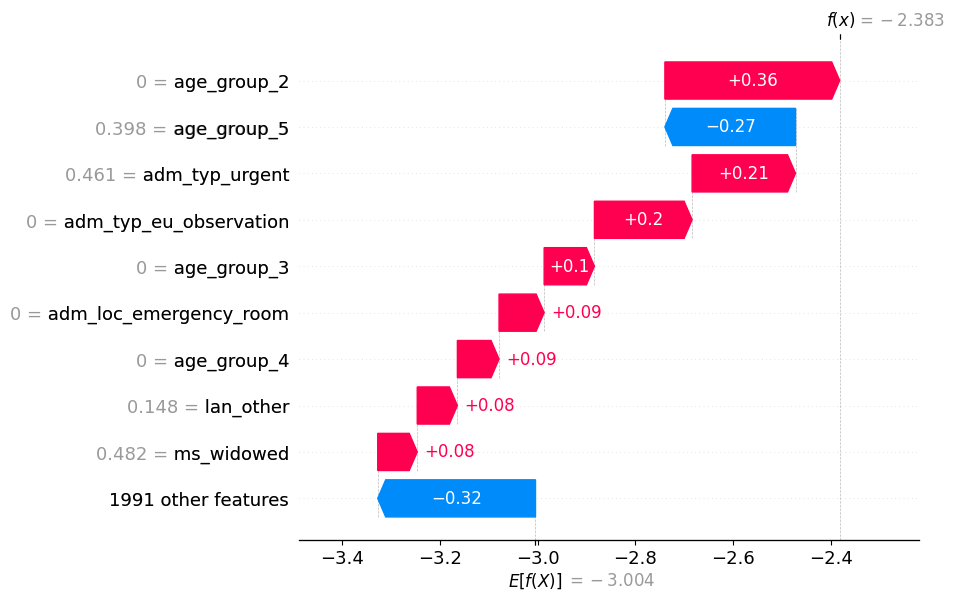

Predicted Probability for Sample 1: 0.05


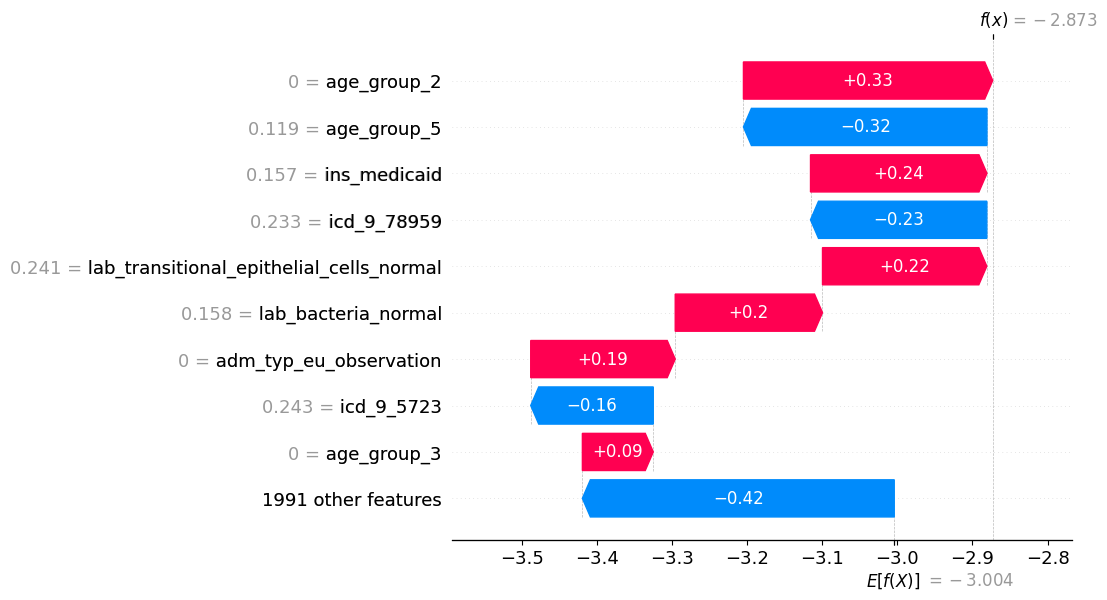

Predicted Probability for Sample 2: 0.04


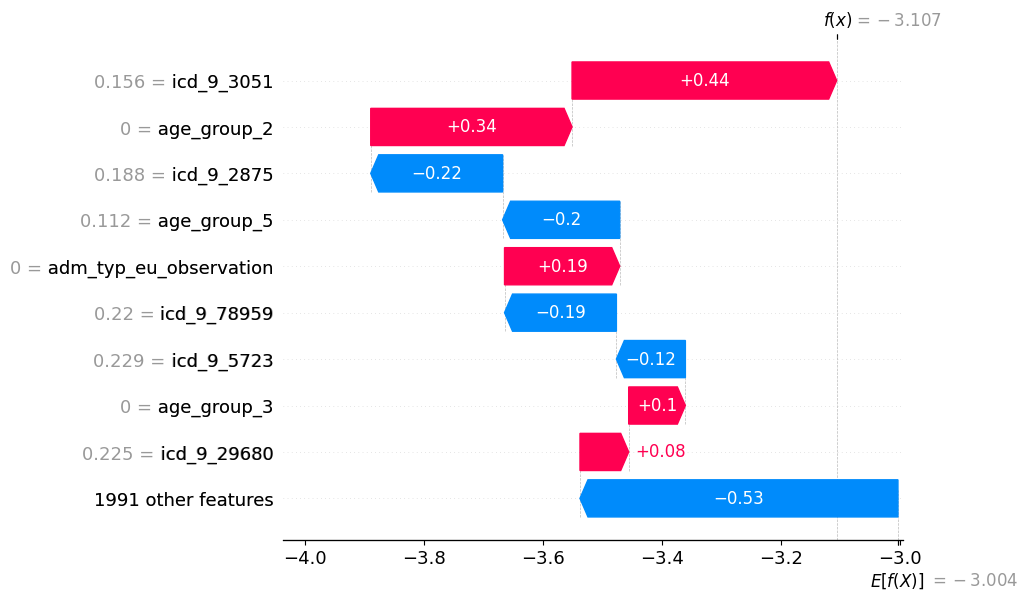

In [41]:
import shap
import numpy as np

# 将稀疏矩阵转换为密集矩阵
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# 创建 SHAP Explainer 对象
explainer = shap.Explainer(model, X_train_dense)


for i in range(0, 3):
    # 选择一个样本进行解释

    shap_values = explainer(X_test_dense[i].reshape(1, -1))

    # 获取样本的 SHAP 值
    shap_values_single = shap_values[0]

    # 输出预测的概率值
    predicted_proba = model.predict_proba(X_test_dense[i].reshape(1, -1))[0, 1]
    print(f"Predicted Probability for Sample {i}: {predicted_proba:.2f}")

    # 使用 waterfall plot 来显示该样本的特征重要性
    shap.waterfall_plot(shap.Explanation(
        values=shap_values_single.values, 
        base_values=shap_values_single.base_values, 
        data=X_test_dense[i],
        feature_names=feature_names
    ))


## 心梗

In [42]:
LABEL = 'MI'

In [43]:
df_training = pd.read_csv(r'D:\data\MIMIC_IV_processed\common\df_training_'+LABEL+'.csv',sep=';')

In [44]:
#排除2010年之前数据，降低数据迁移影响

df_training = df_training[~(df_training.ADMISSION_YEAR_GROUP=='2008 - 2010')]
df_training.reset_index(drop=True, inplace=True)

In [45]:
df_training[LABEL].value_counts()

MI
0    25883
1     5930
Name: count, dtype: int64

In [46]:
df_testing[LABEL].value_counts()

MI
0    44872
1     1488
Name: count, dtype: int64

#### 创建训练数据集

In [47]:
## 定义训练用特征

features_training = [
    'GENDER',
    'AGE_GROUP',
    'ADMISSION_TYPE',
    'DIAGNOSIS_HISTORY',
    'SURGERY_HISTORY',
    'LAB_RESULT',
    'ADMISSION_LOCATION',
    'INSURANCE',
    'LANGUAGE',
    'MARITAL_STATUS',
    'RACE'
    ]      

# 确保所有特征值都是字符串
df_training[features_training] = df_training[features_training].astype(str)

# 初始化 inputs 列表
inputs = []

# 遍历数据框的每一行， 生成observation列，聚集所有特征值，之后在此基础上通过TF-IDF生成特征向量集
for index, row in df_training.iterrows():
    # 用逗号分隔的特征字符串
    observation = ','.join(row[features_training].values)
    observation = observation.replace(',nan', '')
    inputs.append(observation)

# 构建训练数据框
train_data = pd.DataFrame({
    'STAYID': df_training.STAYID,
    'OBSERVATIONS': inputs,
    'LABEL': df_training[LABEL]
})

In [48]:
train_data.head()

,STAYID,OBSERVATIONS,LABEL
0,22097658,"gender_m,age_group_2,adm_typ_eu_observation,ic...",0
1,26066020,"gender_f,age_group_7,adm_typ_urgent,lab_inr_pt...",1
2,26852229,"gender_f,age_group_6,adm_typ_ew_emer_,icd_10_a...",0
3,20978816,"gender_f,age_group_4,adm_typ_observation_admit...",0
4,25843836,"gender_f,age_group_8,adm_typ_observation_admit...",0


#### 创建测试数据集

In [49]:
# 确保所有特征值都是字符串
df_testing[features_training] = df_testing[features_training].astype(str)

# 初始化 inputs 列表
inputs_test = []

# 遍历数据框的每一行
for index, row in df_testing.iterrows():
    # 用逗号分隔的特征字符串
    observation = ','.join(row[features_training].values)
    observation = observation.replace(',nan', '')
    inputs_test.append(observation)

test_data = pd.DataFrame(
    {'STAYID': df_testing.STAYID,
     'OBSERVATIONS': inputs_test,
     'LABEL': df_testing[LABEL]
    })

In [50]:
test_data.head()

,STAYID,OBSERVATIONS,LABEL
0,22595853,"gender_f,age_group_5,adm_typ_urgent,adm_loc_tr...",0
1,22841357,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
2,25742920,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
3,29079034,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
4,24597018,"gender_f,age_group_5,adm_typ_ew_emer_,adm_loc_...",0


## 模型训练

### 使用LGBM, 特征值为2000

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Feature extraction: Convert observations to features using TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer = "word"
                                  , max_features=2000
                                  #, ngram_range = (1,3)
                                  #, max_df = 0.95
                                  #, min_df = 0.05
                                  , dtype = np.float32
                                 )


X_train = vectorizer.fit_transform(train_data['OBSERVATIONS'])

# Label encoding: Convert MI labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data["LABEL"])


X_test = vectorizer.transform(test_data.OBSERVATIONS)
y_test = label_encoder.fit_transform(test_data["LABEL"])


# Model training: Train a RandomForestClassifier
#model = RandomForestClassifier(n_estimators=100, random_state=42)

#model.fit(X_train, y_train)


#model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#    max_depth=1, random_state=0).fit(X_train, y_train)

model = LGBMClassifier()
model.fit(X_train, y_train)

# Model evaluation: Predict on the test set and print the classification report


pred = model.predict(X_test)

conf_mat = confusion_matrix(test_data["LABEL"], pred)

pred_pro = model.predict_proba(X_test)[:,1]

frp_mi, trp_mi, thres_mi = roc_curve(test_data["LABEL"], pred_pro)

auc_val_mi = auc(frp_mi, trp_mi)

print("sensitivity: " + str(round(metrics.recall_score(test_data["LABEL"], pred),2)) + '\n') 
print("specificity: " + str(round(1-metrics.recall_score(1-test_data["LABEL"], pred),2)) + '\n') 
print("discrimination: " + str(round(auc_val_mi,3)) + '\n') 


# Save the model
joblib.dump(model, r'D:\data\MIMIC_IV_processed\common\models\\'+ LABEL+'.pkl')

# Load the model later
#loaded_model = joblib.load('lgbm_model.pkl')

[LightGBM] [Info] Number of positive: 5930, number of negative: 25883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173448
[LightGBM] [Info] Number of data points in the train set: 31813, number of used features: 2000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.186402 -> initscore=-1.473562
[LightGBM] [Info] Start training from score -1.473562
sensitivity: 0.58

specificity: 0.96

discrimination: 0.921



['D:\\data\\MIMIC_IV_processed\\common\\models\\\\MI.pkl']

In [52]:
df_testing['MI_PRED']=pred

In [53]:
df_testing['MI_PRED_PRO']=pred_pro

In [54]:
df_testing[df_testing.MI_PRED==1].head()

,PATIENTID,STAYID,ADMISSION_TIME,DISCHARGE_TIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,MARITAL_STATUS,RACE,...,AS,MI,CI,CASE,AF_PRED,AF_PRED_PRO,AS_PRED,AS_PRED_PRO,MI_PRED,MI_PRED_PRO
13,10002495,24982426,2141-05-22 20:17:00,2141-05-29 17:41:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_medicare,lan_other,ms_married,race_unknown,...,0,1,0,1,1,0.638811,0,0.182126,1,0.955662
61,10013310,21243435,2153-05-26 14:18:00,2153-06-05 19:30:00,adm_typ_observation_admit,adm_loc_information_not_available,ins_medicare,lan_other,ms_single,race_black_african,...,0,1,0,1,0,0.212249,0,0.107928,1,0.955334
62,10013310,22098926,2153-06-10 11:55:00,2153-07-21 18:00:00,adm_typ_observation_admit,adm_loc_information_not_available,ins_medicare,lan_other,ms_single,race_black_african,...,0,0,1,1,0,0.447437,0,0.145281,1,0.581637
75,10015931,22130791,2177-03-24 21:47:00,2177-03-29 14:15:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_medicare,lan_other,ms_married,race_white,...,0,1,0,1,1,0.902463,0,0.210692,1,0.907045
77,10015931,28157142,2176-11-14 18:02:00,2176-11-27 13:30:00,adm_typ_observation_admit,adm_loc_emergency_room,ins_medicare,lan_other,ms_married,race_white,...,0,0,0,1,0,0.457252,0,0.218598,1,0.616493


In [55]:
# 获取特征重要性
feature_importance = model.feature_importances_

# 获取特征名称
feature_names = vectorizer.get_feature_names_out()

# 创建 DataFrame 并按重要性排序
explaining_df = pd.DataFrame({
    "feature_names": feature_names,
    "scores": feature_importance
}).sort_values(by="scores", ascending=False)
explaining_df[:20]

,feature_names,scores
18,age_group_2,59
1015,icd_9_41401,48
6,adm_loc_transfer_from_hospital,47
19,age_group_3,47
13,adm_typ_eu_observation,45
1928,lab_troponin_t_abnormal,45
15,adm_typ_observation_admit,44
1714,lab_creatine_kinase__mb_isoenzyme_abnormal,43
27,gender_m,42
1875,lab_ptt_abnormal,41


Predicted Probability for Sample 0: 0.31


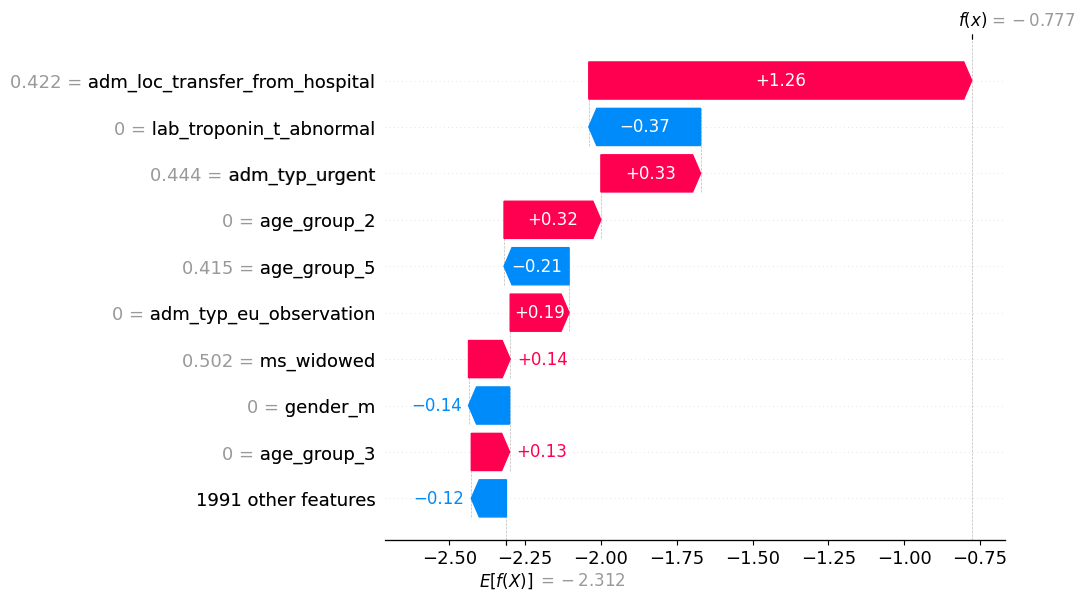

Predicted Probability for Sample 1: 0.03


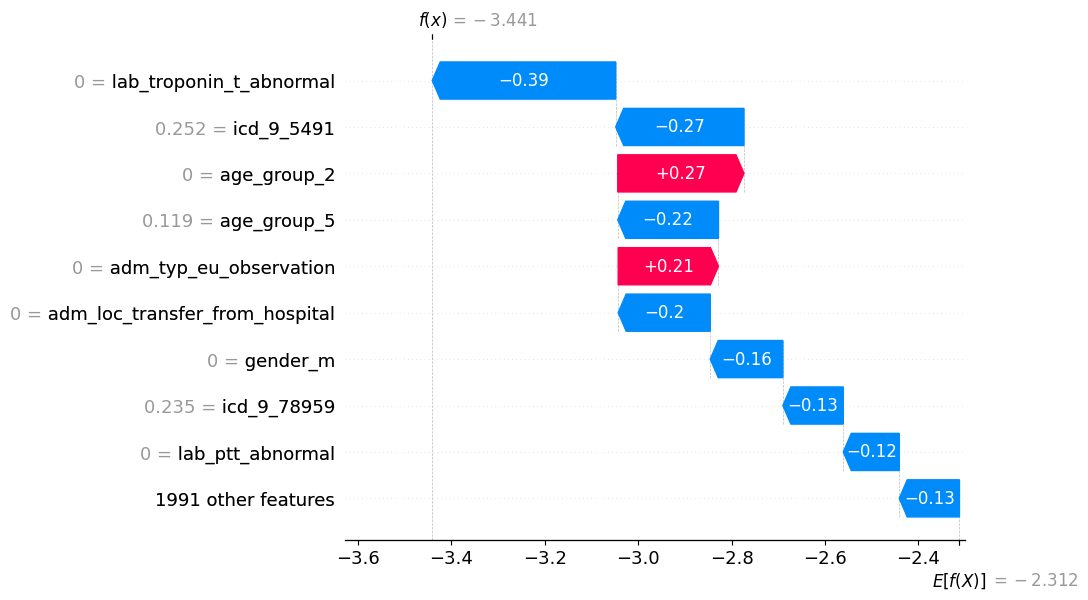

Predicted Probability for Sample 2: 0.04


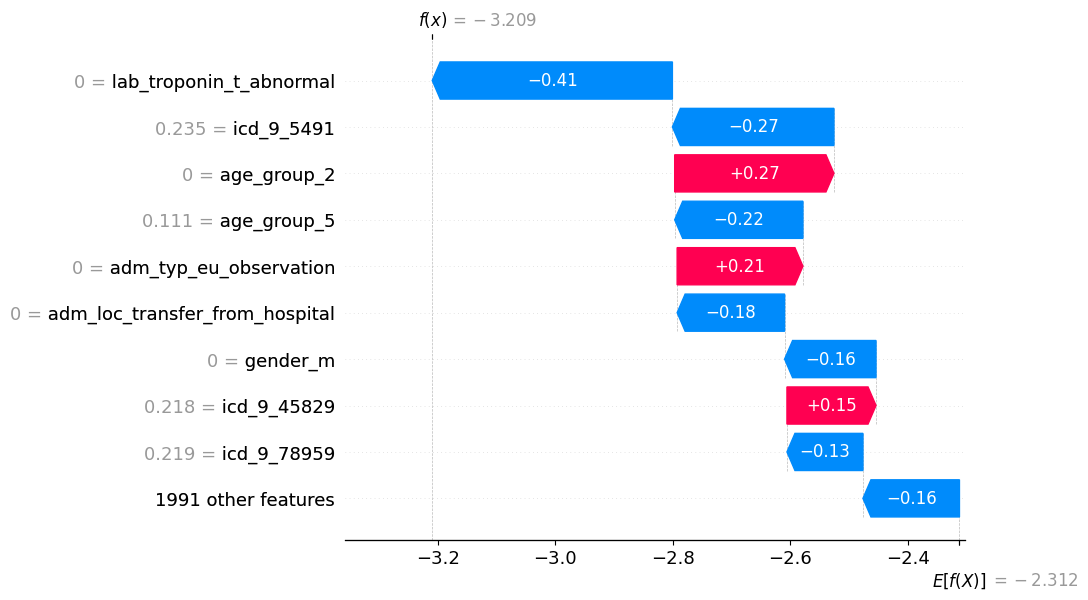

In [56]:
import shap
import numpy as np

# 将稀疏矩阵转换为密集矩阵
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# 创建 SHAP Explainer 对象
explainer = shap.Explainer(model, X_train_dense)


for i in range(0, 3):
    # 选择一个样本进行解释

    shap_values = explainer(X_test_dense[i].reshape(1, -1))

    # 获取样本的 SHAP 值
    shap_values_single = shap_values[0]

    # 输出预测的概率值
    predicted_proba = model.predict_proba(X_test_dense[i].reshape(1, -1))[0, 1]
    print(f"Predicted Probability for Sample {i}: {predicted_proba:.2f}")

    # 使用 waterfall plot 来显示该样本的特征重要性
    shap.waterfall_plot(shap.Explanation(
        values=shap_values_single.values, 
        base_values=shap_values_single.base_values, 
        data=X_test_dense[i],
        feature_names=feature_names
    ))


## 脑梗

In [57]:
LABEL = 'CI'

In [58]:
df_training = pd.read_csv(r'D:\data\MIMIC_IV_processed\common\df_training_'+LABEL+'.csv',sep=';')

In [59]:
#排除2010年之前数据，降低数据迁移影响

df_training = df_training[~(df_training.ADMISSION_YEAR_GROUP=='2008 - 2010')]
df_training.reset_index(drop=True, inplace=True)

In [60]:
df_training[LABEL].value_counts()

CI
0    13585
1     3345
Name: count, dtype: int64

In [61]:
df_testing[LABEL].value_counts()

CI
0    45519
1      841
Name: count, dtype: int64

#### 创建训练数据集

In [62]:
## 定义训练用特征

features_training = [
    'GENDER',
    'AGE_GROUP',
    'ADMISSION_TYPE',
    'DIAGNOSIS_HISTORY',
    'SURGERY_HISTORY',
    'LAB_RESULT',
    'ADMISSION_LOCATION',
    'INSURANCE',
    'LANGUAGE',
    'MARITAL_STATUS',
    'RACE'
    ]      

# 确保所有特征值都是字符串
df_training[features_training] = df_training[features_training].astype(str)

# 初始化 inputs 列表
inputs = []

# 遍历数据框的每一行， 生成observation列，聚集所有特征值，之后在此基础上通过TF-IDF生成特征向量集
for index, row in df_training.iterrows():
    # 用逗号分隔的特征字符串
    observation = ','.join(row[features_training].values)
    observation = observation.replace(',nan', '')
    inputs.append(observation)

# 构建训练数据框
train_data = pd.DataFrame({
    'STAYID': df_training.STAYID,
    'OBSERVATIONS': inputs,
    'LABEL': df_training[LABEL]
})

In [63]:
train_data.head()

,STAYID,OBSERVATIONS,LABEL
0,28899190,"gender_m,age_group_6,adm_typ_ew_emer_,adm_loc_...",1
1,22772230,"gender_f,age_group_8,adm_typ_ew_emer_,lab_thyr...",1
2,23653069,"gender_f,age_group_8,adm_typ_ew_emer_,adm_loc_...",1
3,21105687,"gender_f,age_group_8,adm_typ_ew_emer_,icd_10_e...",1
4,29996921,"gender_f,age_group_7,adm_typ_ew_emer_,lab_inr_...",0


#### 创建测试数据集

In [64]:
# 确保所有特征值都是字符串
df_testing[features_training] = df_testing[features_training].astype(str)

# 初始化 inputs 列表
inputs_test = []

# 遍历数据框的每一行
for index, row in df_testing.iterrows():
    # 用逗号分隔的特征字符串
    observation = ','.join(row[features_training].values)
    observation = observation.replace(',nan', '')
    inputs_test.append(observation)

test_data = pd.DataFrame(
    {'STAYID': df_testing.STAYID,
     'OBSERVATIONS': inputs_test,
     'LABEL': df_testing[LABEL]
    })

In [65]:
test_data.head()

,STAYID,OBSERVATIONS,LABEL
0,22595853,"gender_f,age_group_5,adm_typ_urgent,adm_loc_tr...",0
1,22841357,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
2,25742920,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
3,29079034,"gender_f,age_group_5,adm_typ_ew_emer_,icd_9_07...",0
4,24597018,"gender_f,age_group_5,adm_typ_ew_emer_,adm_loc_...",0


## 模型训练

### 使用LGBM, 特征值为2000

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Feature extraction: Convert observations to features using TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer = "word"
                                  , max_features=2000
                                  #, ngram_range = (1,3)
                                  #, max_df = 0.95
                                  #, min_df = 0.05
                                  , dtype = np.float32
                                 )


X_train = vectorizer.fit_transform(train_data['OBSERVATIONS'])

# Label encoding: Convert MI labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data["LABEL"])


X_test = vectorizer.transform(test_data.OBSERVATIONS)
y_test = label_encoder.fit_transform(test_data["LABEL"])


# Model training: Train a RandomForestClassifier
#model = RandomForestClassifier(n_estimators=100, random_state=42)

#model.fit(X_train, y_train)


#model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#    max_depth=1, random_state=0).fit(X_train, y_train)

model = LGBMClassifier()
model.fit(X_train, y_train)

# Model evaluation: Predict on the test set and print the classification report


pred = model.predict(X_test)

conf_mat = confusion_matrix(test_data["LABEL"], pred)

pred_pro = model.predict_proba(X_test)[:,1]

frp_mi, trp_mi, thres_mi = roc_curve(test_data["LABEL"], pred_pro)

auc_val_mi = auc(frp_mi, trp_mi)

print("sensitivity: " + str(round(metrics.recall_score(test_data["LABEL"], pred),2)) + '\n') 
print("specificity: " + str(round(1-metrics.recall_score(1-test_data["LABEL"], pred),2)) + '\n') 
print("discrimination: " + str(round(auc_val_mi,3)) + '\n') 


# Save the model
joblib.dump(model, r'D:\data\MIMIC_IV_processed\common\models\\'+ LABEL+'.pkl')

# Load the model later
#loaded_model = joblib.load('lgbm_model.pkl')

[LightGBM] [Info] Number of positive: 3345, number of negative: 13585
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114685
[LightGBM] [Info] Number of data points in the train set: 16930, number of used features: 2000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197578 -> initscore=-1.401500
[LightGBM] [Info] Start training from score -1.401500
sensitivity: 0.34

specificity: 0.96

discrimination: 0.844



['D:\\data\\MIMIC_IV_processed\\common\\models\\\\CI.pkl']

In [67]:
df_testing['CI_PRED']=pred

In [68]:
df_testing['CI_PRED_PRO']=pred_pro

In [69]:
df_testing[df_testing.CI_PRED==1].head()

,PATIENTID,STAYID,ADMISSION_TIME,DISCHARGE_TIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,MARITAL_STATUS,RACE,...,CI,CASE,AF_PRED,AF_PRED_PRO,AS_PRED,AS_PRED_PRO,MI_PRED,MI_PRED_PRO,CI_PRED,CI_PRED_PRO
7,10001843,21728396,2131-11-09 16:05:00,2131-11-11 11:23:00,adm_typ_observation_admit,adm_loc_transfer_from_hospital,ins_other,lan_other,ms_single,race_white,...,0,1,0,0.297184,0,0.189390,0,0.349643,1,0.507437
13,10002495,24982426,2141-05-22 20:17:00,2141-05-29 17:41:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_medicare,lan_other,ms_married,race_unknown,...,0,1,1,0.638811,0,0.182126,1,0.955662,1,0.622156
22,10004606,23517634,2159-03-14 20:02:00,2159-03-22 14:00:00,adm_typ_observation_admit,adm_loc_physician_referral,ins_other,lan_other,ms_widowed,race_white,...,0,1,0,0.059369,1,0.790913,0,0.117200,1,0.504707
33,10006029,29107716,2169-08-20 16:50:00,2169-08-22 14:55:00,adm_typ_observation_admit,adm_loc_clinic_referral,ins_medicare,lan_other,ms_married,race_white,...,0,0,0,0.371792,0,0.067772,0,0.063685,1,0.577184
56,10010440,26812050,2173-08-07 20:34:00,2173-08-19 14:01:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_other,lan_other,ms_divorced,race_black_african_american,...,0,0,0,0.120484,0,0.135737,0,0.136088,1,0.659442


In [70]:
# 获取特征重要性
feature_importance = model.feature_importances_

# 获取特征名称
feature_names = vectorizer.get_feature_names_out()

# 创建 DataFrame 并按重要性排序
explaining_df = pd.DataFrame({
    "feature_names": feature_names,
    "scores": feature_importance
}).sort_values(by="scores", ascending=False)
explaining_df[:20]

,feature_names,scores
15,adm_typ_ew_emer_,44
7,adm_loc_transfer_from_hospital,40
16,adm_typ_observation_admit,37
19,age_group_2,35
1969,ms_married,32
14,adm_typ_eu_observation,30
24,age_group_7,28
28,gender_m,27
20,age_group_3,26
1527,icd_9_v1254,26


In [71]:
df_testing[df_testing.CI_PRED==1].head()

,PATIENTID,STAYID,ADMISSION_TIME,DISCHARGE_TIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,MARITAL_STATUS,RACE,...,CI,CASE,AF_PRED,AF_PRED_PRO,AS_PRED,AS_PRED_PRO,MI_PRED,MI_PRED_PRO,CI_PRED,CI_PRED_PRO
7,10001843,21728396,2131-11-09 16:05:00,2131-11-11 11:23:00,adm_typ_observation_admit,adm_loc_transfer_from_hospital,ins_other,lan_other,ms_single,race_white,...,0,1,0,0.297184,0,0.189390,0,0.349643,1,0.507437
13,10002495,24982426,2141-05-22 20:17:00,2141-05-29 17:41:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_medicare,lan_other,ms_married,race_unknown,...,0,1,1,0.638811,0,0.182126,1,0.955662,1,0.622156
22,10004606,23517634,2159-03-14 20:02:00,2159-03-22 14:00:00,adm_typ_observation_admit,adm_loc_physician_referral,ins_other,lan_other,ms_widowed,race_white,...,0,1,0,0.059369,1,0.790913,0,0.117200,1,0.504707
33,10006029,29107716,2169-08-20 16:50:00,2169-08-22 14:55:00,adm_typ_observation_admit,adm_loc_clinic_referral,ins_medicare,lan_other,ms_married,race_white,...,0,0,0,0.371792,0,0.067772,0,0.063685,1,0.577184
56,10010440,26812050,2173-08-07 20:34:00,2173-08-19 14:01:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_other,lan_other,ms_divorced,race_black_african_american,...,0,0,0,0.120484,0,0.135737,0,0.136088,1,0.659442


In [72]:
df_testing[df_testing.MI_PRED==1].head()

,PATIENTID,STAYID,ADMISSION_TIME,DISCHARGE_TIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,MARITAL_STATUS,RACE,...,CI,CASE,AF_PRED,AF_PRED_PRO,AS_PRED,AS_PRED_PRO,MI_PRED,MI_PRED_PRO,CI_PRED,CI_PRED_PRO
13,10002495,24982426,2141-05-22 20:17:00,2141-05-29 17:41:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_medicare,lan_other,ms_married,race_unknown,...,0,1,1,0.638811,0,0.182126,1,0.955662,1,0.622156
61,10013310,21243435,2153-05-26 14:18:00,2153-06-05 19:30:00,adm_typ_observation_admit,adm_loc_information_not_available,ins_medicare,lan_other,ms_single,race_black_african,...,0,1,0,0.212249,0,0.107928,1,0.955334,0,0.115046
62,10013310,22098926,2153-06-10 11:55:00,2153-07-21 18:00:00,adm_typ_observation_admit,adm_loc_information_not_available,ins_medicare,lan_other,ms_single,race_black_african,...,1,1,0,0.447437,0,0.145281,1,0.581637,1,0.670959
75,10015931,22130791,2177-03-24 21:47:00,2177-03-29 14:15:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_medicare,lan_other,ms_married,race_white,...,0,1,1,0.902463,0,0.210692,1,0.907045,0,0.105123
77,10015931,28157142,2176-11-14 18:02:00,2176-11-27 13:30:00,adm_typ_observation_admit,adm_loc_emergency_room,ins_medicare,lan_other,ms_married,race_white,...,0,1,0,0.457252,0,0.218598,1,0.616493,0,0.147825


In [73]:
df_testing[df_testing.AF_PRED==1].head()

,PATIENTID,STAYID,ADMISSION_TIME,DISCHARGE_TIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,MARITAL_STATUS,RACE,...,CI,CASE,AF_PRED,AF_PRED_PRO,AS_PRED,AS_PRED_PRO,MI_PRED,MI_PRED_PRO,CI_PRED,CI_PRED_PRO
8,10002221,20195471,2203-06-13 00:00:00,2203-06-16 13:28:00,adm_typ_surgical_same_day_admission,adm_loc_physician_referral,ins_medicare,lan_other,ms_single,race_white,...,0,0,1,0.568026,0,0.119561,0,0.016046,0,0.132697
11,10002221,21729093,2204-06-27 16:57:00,2204-06-30 12:53:00,adm_typ_observation_admit,adm_loc_clinic_referral,ins_medicare,lan_other,ms_single,race_white,...,0,0,1,0.592364,0,0.224838,0,0.021736,0,0.346882
12,10002221,29399017,2204-07-17 06:10:00,2204-07-25 14:05:00,adm_typ_ew_emer_,adm_loc_physician_referral,ins_medicare,lan_other,ms_single,race_white,...,0,0,1,0.567972,0,0.047035,0,0.036686,0,0.313374
13,10002495,24982426,2141-05-22 20:17:00,2141-05-29 17:41:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_medicare,lan_other,ms_married,race_unknown,...,0,1,1,0.638811,0,0.182126,1,0.955662,1,0.622156
18,10004235,22187210,2196-06-20 21:11:00,2196-06-22 13:30:00,adm_typ_direct_emer_,adm_loc_physician_referral,ins_medicaid,lan_other,ms_single,race_black_cape_verdean,...,0,1,1,0.676603,0,0.025294,0,0.055464,0,0.036346


Predicted Probability for Sample 0: 0.34


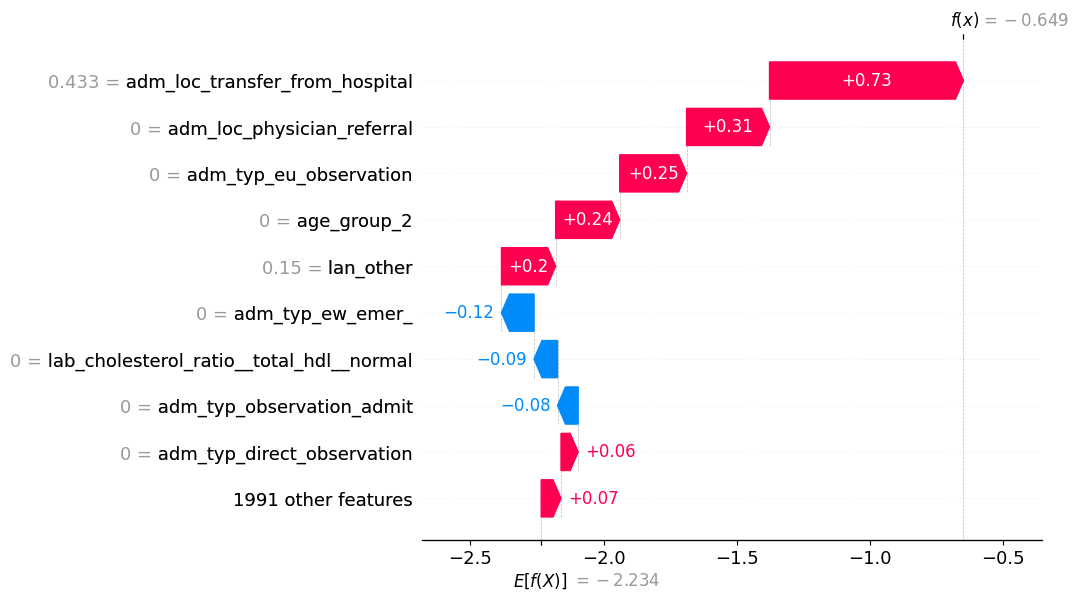

Predicted Probability for Sample 1: 0.04


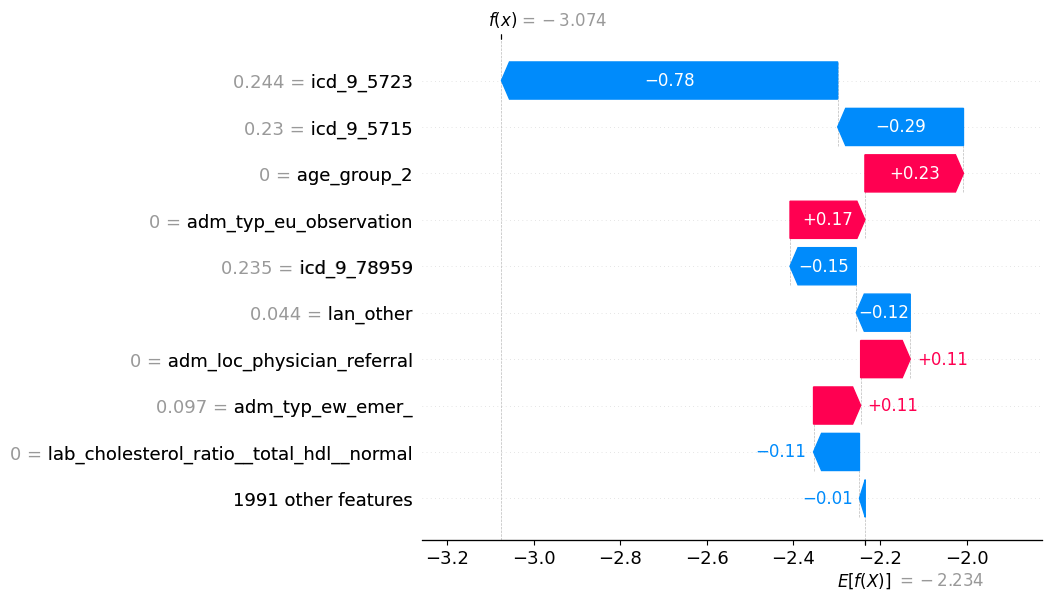

Predicted Probability for Sample 2: 0.02


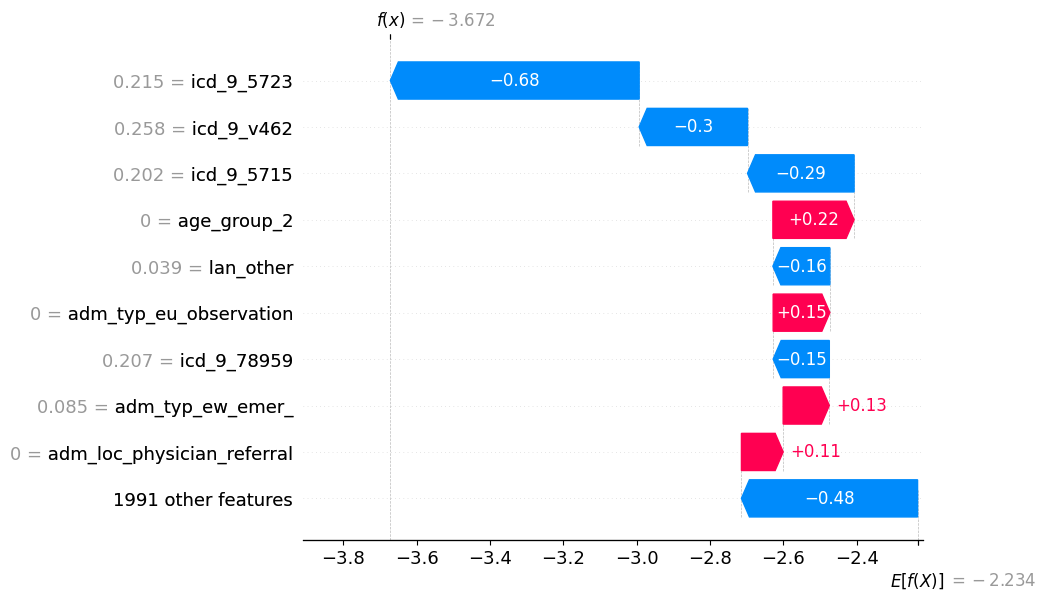

In [74]:
import shap
import numpy as np

# 将稀疏矩阵转换为密集矩阵
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# 创建 SHAP Explainer 对象
explainer = shap.Explainer(model, X_train_dense)


for i in range(0, 3):
    # 选择一个样本进行解释

    shap_values = explainer(X_test_dense[i].reshape(1, -1))

    # 获取样本的 SHAP 值
    shap_values_single = shap_values[0]

    # 输出预测的概率值
    predicted_proba = model.predict_proba(X_test_dense[i].reshape(1, -1))[0, 1]
    print(f"Predicted Probability for Sample {i}: {predicted_proba:.2f}")

    # 使用 waterfall plot 来显示该样本的特征重要性
    shap.waterfall_plot(shap.Explanation(
        values=shap_values_single.values, 
        base_values=shap_values_single.base_values, 
        data=X_test_dense[i],
        feature_names=feature_names
    ))


In [75]:
df_testing[:20].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
PATIENTID,10000032,10000032,10000032,10000032,10001217,10001217,10001472,10001843,10002221,10002221,10002221,10002221,10002221,10002495,10002751,10003046,10003731,10003731,10004235,10004235
STAYID,22595853,22841357,25742920,29079034,24597018,27703517,23506139,21728396,20195471,20237862,21008195,21729093,29399017,24982426,22002850,26048429,23646008,24817944,22187210,24181354
ADMISSION_TIME,2180-05-06 22:23:00,2180-06-26 18:27:00,2180-08-05 23:44:00,2180-07-23 12:35:00,2157-11-18 22:56:00,2157-12-18 16:58:00,2186-01-10 00:00:00,2131-11-09 16:05:00,2203-06-13 00:00:00,2204-07-03 22:34:00,2200-09-29 17:28:00,2204-06-27 16:57:00,2204-07-17 06:10:00,2141-05-22 20:17:00,2174-02-08 11:21:00,2154-01-02 07:15:00,2146-11-18 00:45:00,2152-04-13 00:00:00,2196-06-20 21:11:00,2196-02-24 14:38:00
DISCHARGE_TIME,2180-05-07 17:15:00,2180-06-27 18:49:00,2180-08-07 17:50:00,2180-07-25 17:55:00,2157-11-25 18:00:00,2157-12-24 14:55:00,2186-01-13 15:02:00,2131-11-11 11:23:00,2203-06-16 13:28:00,2204-07-06 15:00:00,2200-10-01 14:58:00,2204-06-30 12:53:00,2204-07-25 14:05:00,2141-05-29 17:41:00,2174-02-09 13:00:00,2154-01-09 11:53:00,2146-11-19 16:07:00,2152-04-14 19:05:00,2196-06-22 13:30:00,2196-03-04 14:02:00
ADMISSION_TYPE,adm_typ_urgent,adm_typ_ew_emer_,adm_typ_ew_emer_,adm_typ_ew_emer_,adm_typ_ew_emer_,adm_typ_direct_emer_,adm_typ_urgent,adm_typ_observation_admit,adm_typ_surgical_same_day_admission,adm_typ_ew_emer_,adm_typ_ew_emer_,adm_typ_observation_admit,adm_typ_ew_emer_,adm_typ_urgent,adm_typ_ew_emer_,adm_typ_surgical_same_day_admission,adm_typ_ew_emer_,adm_typ_surgical_same_day_admission,adm_typ_direct_emer_,adm_typ_urgent
ADMISSION_LOCATION,adm_loc_transfer_from_hospital,adm_loc_emergency_room,adm_loc_emergency_room,adm_loc_emergency_room,adm_loc_emergency_room,adm_loc_physician_referral,adm_loc_physician_referral,adm_loc_transfer_from_hospital,adm_loc_physician_referral,adm_loc_physician_referral,adm_loc_emergency_room,adm_loc_clinic_referral,adm_loc_physician_referral,adm_loc_transfer_from_hospital,adm_loc_emergency_room,adm_loc_physician_referral,adm_loc_emergency_room,adm_loc_physician_referral,adm_loc_physician_referral,adm_loc_transfer_from_hospital
INSURANCE,ins_other,ins_medicaid,ins_medicaid,ins_medicaid,ins_other,ins_other,ins_other,ins_other,ins_medicare,ins_medicare,ins_medicare,ins_medicare,ins_medicare,ins_medicare,ins_other,ins_other,ins_other,ins_medicare,ins_medicaid,ins_medicaid
LANGUAGE,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other
MARITAL_STATUS,ms_widowed,ms_widowed,ms_widowed,ms_widowed,ms_married,ms_married,ms_married,ms_single,ms_single,ms_single,ms_single,ms_single,ms_single,ms_married,ms_married,ms_single,ms_single,ms_single,ms_single,ms_single
RACE,race_white,race_white,race_white,race_white,race_white,race_white,race_white,race_white,race_white,race_white,race_white,race_white,race_white,race_unknown,race_white,race_white,race_white,race_white___other_european,race_black_cape_verdean,race_black_cape_verdean


In [76]:
df_testing[10000:10025].T

,10000,10001,10002,10003,10004,10005,10006,10007,10008,10009,...,10015,10016,10017,10018,10019,10020,10021,10022,10023,10024
PATIENTID,12143438,12143438,12143980,12143980,12143980,12143980,12145036,12145110,12145110,12145110,...,12145339,12145339,12145339,12145339,12145339,12145339,12145339,12145613,12145613,12146331
STAYID,21809757,29245583,20705175,23103283,26395235,28810801,20327262,20415149,22107104,25132373,...,22489226,22896410,23231718,23449063,24587183,25669329,26417388,27194141,29989629,20193192
ADMISSION_TIME,2128-10-19 21:50:00,2122-05-05 16:07:00,2161-09-10 08:23:00,2161-11-18 22:29:00,2161-09-23 14:22:00,2161-07-24 00:00:00,2158-01-15 14:36:00,2132-09-24 09:42:00,2131-01-02 18:19:00,2130-12-14 01:10:00,...,2134-02-02 20:21:00,2134-05-25 16:48:00,2133-08-16 11:50:00,2134-06-12 11:41:00,2134-09-01 18:51:00,2133-12-29 12:50:00,2135-09-06 19:02:00,2144-05-07 04:23:00,2144-04-23 01:39:00,2165-05-24 10:09:00
DISCHARGE_TIME,2128-10-20 11:14:00,2122-05-05 22:42:00,2161-09-14 17:32:00,2161-11-29 14:18:00,2161-10-03 16:25:00,2161-07-31 15:55:00,2158-01-15 18:39:00,2132-09-30 17:10:00,2131-01-05 15:15:00,2130-12-18 17:00:00,...,2134-02-12 18:13:00,2134-05-30 17:13:00,2133-08-19 17:00:00,2134-06-16 14:24:00,2134-09-04 18:50:00,2133-12-30 17:00:00,2135-09-15 14:45:00,2144-05-11 16:40:00,2144-05-01 17:45:00,2165-05-28 13:15:00
ADMISSION_TYPE,adm_typ_eu_observation,adm_typ_eu_observation,adm_typ_urgent,adm_typ_urgent,adm_typ_urgent,adm_typ_urgent,adm_typ_direct_observation,adm_typ_observation_admit,adm_typ_observation_admit,adm_typ_surgical_same_day_admission,...,adm_typ_observation_admit,adm_typ_observation_admit,adm_typ_observation_admit,adm_typ_observation_admit,adm_typ_observation_admit,adm_typ_ew_emer_,adm_typ_observation_admit,adm_typ_ew_emer_,adm_typ_observation_admit,adm_typ_urgent
ADMISSION_LOCATION,adm_loc_walk_in_self_referral,adm_loc_emergency_room,adm_loc_transfer_from_hospital,adm_loc_transfer_from_hospital,adm_loc_transfer_from_hospital,adm_loc_transfer_from_hospital,adm_loc_physician_referral,adm_loc_walk_in_self_referral,adm_loc_physician_referral,adm_loc_physician_referral,...,adm_loc_physician_referral,adm_loc_clinic_referral,adm_loc_emergency_room,adm_loc_walk_in_self_referral,adm_loc_physician_referral,adm_loc_emergency_room,adm_loc_walk_in_self_referral,adm_loc_physician_referral,adm_loc_physician_referral,adm_loc_physician_referral
INSURANCE,ins_other,ins_other,ins_other,ins_other,ins_other,ins_other,ins_medicare,ins_medicare,ins_medicare,ins_medicare,...,ins_medicare,ins_medicare,ins_medicare,ins_medicare,ins_medicare,ins_medicare,ins_medicare,ins_other,ins_medicare,ins_other
LANGUAGE,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,...,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other,lan_other
MARITAL_STATUS,ms_married,ms_married,ms_married,ms_married,ms_married,ms_married,ms_widowed,ms_widowed,ms_married,ms_married,...,ms_single,ms_single,ms_single,ms_single,ms_single,ms_single,ms_single,ms_divorced,ms_divorced,ms_married
RACE,race_asian,race_asian,race_white,race_white,race_white,race_white,race_white,race_white,race_white,race_white,...,race_hispanic_latino___guatemalan,race_hispanic_latino___guatemalan,race_hispanic_latino___guatemalan,race_hispanic_latino___guatemalan,race_hispanic_latino___guatemalan,race_hispanic_latino___guatemalan,race_hispanic_latino___guatemalan,race_white,race_white,race_black_african


In [77]:
df_testing[10000:10200][df_testing.CI==1]

C:\Users\hongs\AppData\Local\Temp\ipykernel_32928\2350453177.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_testing[10000:10200][df_testing.CI==1]


,PATIENTID,STAYID,ADMISSION_TIME,DISCHARGE_TIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,MARITAL_STATUS,RACE,...,CI,CASE,AF_PRED,AF_PRED_PRO,AS_PRED,AS_PRED_PRO,MI_PRED,MI_PRED_PRO,CI_PRED,CI_PRED_PRO
10049,12151872,22742705,2124-02-25 11:55:00,2124-03-20 11:35:00,adm_typ_observation_admit,adm_loc_physician_referral,ins_medicare,lan_other,ms_married,race_white,...,1,1,0,0.410931,0,0.190289,0,0.216321,0,0.249251
10065,12155780,20253357,2138-08-18 20:09:00,2138-08-30 15:15:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_other,lan_other,ms_married,race_asian,...,1,1,0,0.084871,0,0.011351,0,0.149833,0,0.478380
10066,12155780,24079706,2138-07-01 00:00:00,2138-07-15 18:44:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_other,lan_other,ms_married,race_asian,...,1,1,0,0.054825,0,0.021305,1,0.901499,0,0.112887
10178,12190973,25768502,2171-06-19 23:42:00,2171-06-25 16:23:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_medicare,lan_other,ms_single,race_white,...,1,1,0,0.296796,0,0.126279,0,0.170851,0,0.376397


In [78]:
len(df_testing)

46360

In [79]:
df_testing[10000:11000][df_testing.CI_PRED==1]

C:\Users\hongs\AppData\Local\Temp\ipykernel_32928\1441959469.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_testing[10000:11000][df_testing.CI_PRED==1]


,PATIENTID,STAYID,ADMISSION_TIME,DISCHARGE_TIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,MARITAL_STATUS,RACE,...,CI,CASE,AF_PRED,AF_PRED_PRO,AS_PRED,AS_PRED_PRO,MI_PRED,MI_PRED_PRO,CI_PRED,CI_PRED_PRO
10011,12145235,21446190,2176-03-02 03:30:00,2176-03-02 06:52:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_medicare,lan_other,ms_nan,race_unknown,...,0,0,0,0.193937,0,0.134250,1,0.532077,1,0.662564
10062,12155413,27296628,2185-11-03 22:33:00,2185-11-14 13:00:00,adm_typ_urgent,adm_loc_transfer_from_hospital,ins_medicare,lan_other,ms_divorced,race_white,...,0,1,0,0.497759,0,0.110809,0,0.202216,1,0.537155
10092,12163461,23378652,2145-12-18 14:16:00,2146-01-10 12:30:00,adm_typ_ew_emer_,adm_loc_physician_referral,ins_other,lan_other,ms_married,race_other,...,0,0,0,0.043361,0,0.040471,0,0.103811,1,0.908727
10098,12166102,25788094,2132-11-07 02:04:00,2132-11-09 17:45:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_other,lan_other,ms_married,race_unknown,...,0,0,0,0.321099,0,0.153090,1,0.587561,1,0.916362
10119,12170291,25905147,2131-09-01 15:22:00,2131-09-13 14:40:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_other,lan_other,ms_married,race_white,...,0,1,0,0.263459,0,0.159148,0,0.078733,1,0.542482
10130,12173825,27348167,2122-03-12 22:04:00,2122-03-14 13:35:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_other,lan_other,ms_nan,race_unknown,...,0,0,0,0.092155,0,0.131380,0,0.105393,1,0.568639
10155,12180204,22203979,2115-07-07 04:13:00,2115-07-10 17:50:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_other,lan_other,ms_divorced,race_white,...,0,1,0,0.259892,0,0.133136,1,0.648717,1,0.717553
10204,12202842,21742799,2132-04-21 11:12:00,2132-04-24 15:09:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_other,lan_other,ms_married,race_white,...,0,0,0,0.187625,0,0.044091,0,0.120872,1,0.692877
10213,12203981,20197074,2165-10-25 00:55:00,2165-10-26 20:20:00,adm_typ_observation_admit,adm_loc_physician_referral,ins_other,lan_other,ms_married,race_white,...,1,1,0,0.046017,0,0.043408,0,0.224558,1,0.795223
10232,12210501,25092409,2180-11-06 22:53:00,2180-11-09 03:54:00,adm_typ_ew_emer_,adm_loc_emergency_room,ins_medicaid,lan_other,ms_nan,race_unknown,...,0,0,0,0.039118,0,0.029558,0,0.121496,1,0.521220
